Задача авторегрессии. На вход подается последовательность (синусоида с произвольной апмплитудой и частотой за время t) длины k, необходимо предсказать n = 30 значений в интервале $t \in [t_k,t_{k+n}]$

In [57]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
def gen_data(batch = 16):
    t = np.arange(0,torch.randint(5,15,(1,)),step=0.1)
    X = torch.zeros(t.size-30,batch,1)
    Y = torch.zeros(30,batch,1)
    for i in range(batch):
        a = torch.rand(1)*3 + 0.1
        
        b = torch.rand(1)*4 + 0.2
        
        #X[i,:,0] =  torch.tensor(t)
        y = a*np.sin(b*t)
        X[:,i,0] =  y[:-30]
        Y[:,i,0] = y[-30:]
    return X,Y

In [154]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, encoder_outputs, hidden_state):
        seq_len = encoder_outputs.size(0)
        hidden_state = hidden_state.squeeze(0).unsqueeze(1).repeat(1, seq_len, 1)
        energy = F.tanh(self.attn(torch.cat((hidden_state, encoder_outputs.permute(1, 0, 2)), dim=2)))
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.permute(0, 2, 1), encoder_outputs.permute(1, 0, 2))
        
        return context
    
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.GRU(input_size, hidden_size).to(device)
        self.decoder = nn.GRU(output_size, hidden_size).to(device)
        self.linear = nn.Linear(hidden_size*2, output_size).to(device)
        self.attention = Attention(hidden_size).to(device)
    
    def forward(self, input_seq, teacher_forcing_ratio=0.5):
        encoder_outputs, hidden_state = self.encoder(input_seq)
        #  
        batch_size = input_seq.size(1)
        decoder_input = torch.zeros(1, batch_size, 1).to(device)  # Начальное значение декодера
        
        outputs = []
        for i in range(target_sequence.size(0)):
            
            decoder_output, hidden_state = self.decoder(decoder_input, hidden_state)
            context = self.attention(encoder_outputs, hidden_state)
            #print(context.shape,decoder_output.shape)
            decoder_output = torch.cat((context.permute(1,0,2),hidden_state),2)
            output = self.linear(decoder_output)
            outputs.append(output)
            
            # Используем учителя для обучения (иногда показываем нейросети реальные данные). Это позволяет обучаться быстрее и эффективнее
            use_teacher_forcing = np.random.random() < teacher_forcing_ratio
            if use_teacher_forcing:
                decoder_input = target_sequence[i].unsqueeze(0)
            else:
                decoder_input = output
        
        outputs = torch.cat(outputs, dim=0)
        return outputs
    
model = Seq2Seq(1,32,1).to(device)

In [162]:
#model = Seq2Seq(1,32,1).to(device)
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Обучение модели
s = []
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    input_sequence,target_sequence =  gen_data(batch=16)
    input_sequence = input_sequence.to(device)
    target_sequence = target_sequence.to(device)
    output = model(input_sequence,teacher_forcing_ratio=0.5)

    
    loss = criterion(output, target_sequence)
    loss.backward()
    optimizer.step()
    s.append(loss.detach().to('cpu'))

    if (epoch + 1) % 100 == 0:
        S = np.mean(s)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {S:.4f}')
        s = []

Epoch [100/10000], Loss: 0.0044
Epoch [200/10000], Loss: 0.0039
Epoch [300/10000], Loss: 0.0049
Epoch [400/10000], Loss: 0.0086
Epoch [500/10000], Loss: 0.0044
Epoch [600/10000], Loss: 0.0073
Epoch [700/10000], Loss: 0.0019
Epoch [800/10000], Loss: 0.0027
Epoch [900/10000], Loss: 0.0097
Epoch [1000/10000], Loss: 0.0109
Epoch [1100/10000], Loss: 0.0123
Epoch [1200/10000], Loss: 0.0022
Epoch [1300/10000], Loss: 0.0035
Epoch [1400/10000], Loss: 0.0030
Epoch [1500/10000], Loss: 0.0015
Epoch [1600/10000], Loss: 0.0039
Epoch [1700/10000], Loss: 0.0021
Epoch [1800/10000], Loss: 0.0022
Epoch [1900/10000], Loss: 0.0029
Epoch [2000/10000], Loss: 0.0028
Epoch [2100/10000], Loss: 0.0047
Epoch [2200/10000], Loss: 0.0046
Epoch [2300/10000], Loss: 0.0031
Epoch [2400/10000], Loss: 0.0117
Epoch [2500/10000], Loss: 0.0019
Epoch [2600/10000], Loss: 0.0018
Epoch [2700/10000], Loss: 0.0057
Epoch [2800/10000], Loss: 0.0082
Epoch [2900/10000], Loss: 0.0017
Epoch [3000/10000], Loss: 0.0020
Epoch [3100/10000],

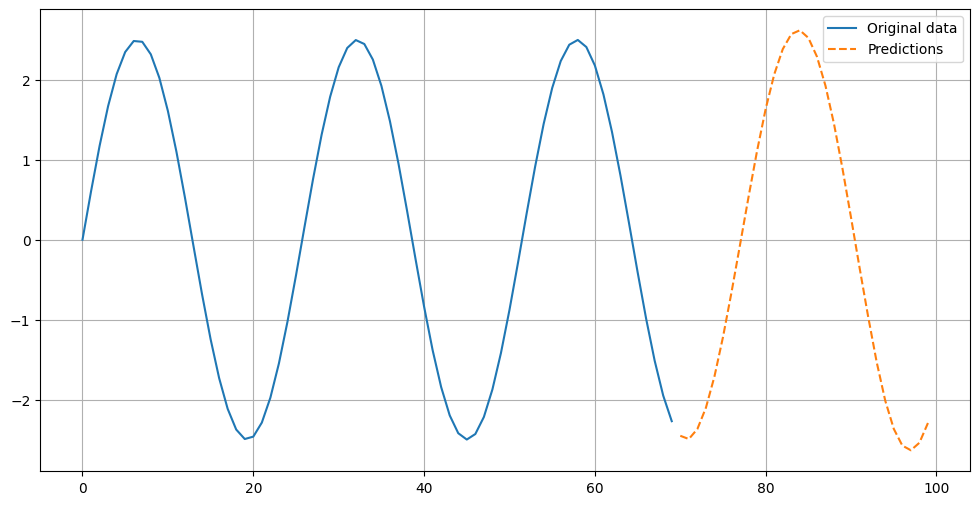

In [173]:
device = 'cpu'
x,y = gen_data(batch = 1)
#x,y=x.to(device), y.to(device)
model = model.to('cpu')
target_sequence = y
output = model(x,teacher_forcing_ratio = 0)
output = output.detach().squeeze()

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(x)),x.detach().squeeze() , label='Original data')
plt.plot(np.arange(len(x), len(x)+30), output, label='Predictions', linestyle='dashed')
plt.legend()
plt.grid(True)
plt.show()